## Import Libraries


### General


In [1]:
import pandas as pd
from datasets import Dataset
import numpy as np
import os
os.environ["WANDB_DISABLED"] = "true"

### Training


In [2]:
import torch
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, AutoTokenizer, TrainerCallback
from torch.nn.functional import softmax
from transformers import MobileBertForSequenceClassification, MobileBertTokenizer

2025-02-16 08:02:57.170573: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import torch.nn as nn
import torch.nn.functional as F

In [4]:
import matplotlib.pyplot as plt

### Metrics


In [5]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve

### Config


In [6]:
pd.set_option('display.max_rows', 20)  
pd.set_option('display.max_columns', 20) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print("CUDA available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")


Using device: cuda
CUDA available: True
GPU Name: NVIDIA GeForce RTX 3050 Ti Laptop GPU


## Preprocessing


In [7]:
df = pd.read_csv('super_sms_dataset.csv', encoding='latin-1')
df['label'] = df['Labels'].fillna(0)
df['sms'] = df['SMSes'].astype(str).dropna()
df['label']=df['label'].astype(int)
df = df[['sms', 'label']]
df

,sms,label
0,There be an update for your delivery CC 017281...,1
1,watch your favorite english movies of all genr...,1
2,aur what is the status for fms,0
3,hi shalini sundi thank you for dialling speci...,1
4,m tryin to understand too...,0
...,...,...
67005,Haha sorry I will be arriving late.,0
67006,Not going out today something cropped up I am ...,0
67007,No no I didn't decide not to turn up I oversle...,0
67008,Spring apartment homes,0


In [8]:
from sklearn.model_selection import train_test_split

texts = df['sms'].tolist()
labels = df['label'].tolist()

train_texts, test_texts, train_labels, test_labels = train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

print(f"Train size: {len(train_texts)}, Test size: {len(test_texts)}")

Train size: 53608, Test size: 13402


In [9]:
class SpamDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

## Training Models


In [10]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch"
)

# Load MobileBERT
mobilebert_model = MobileBertForSequenceClassification.from_pretrained('google/mobilebert-uncased', num_labels=2)
mobilebert_tokenizer = MobileBertTokenizer.from_pretrained('google/mobilebert-uncased')
# Tokenization
train_encodings_mobilebert = mobilebert_tokenizer(train_texts, padding="max_length",
                     truncation=True,
                     max_length=128)
test_encodings_mobilebert = mobilebert_tokenizer(test_texts, padding="max_length",
                     truncation=True,
                     max_length=128)

train_dataset_mobilebert = SpamDataset(train_encodings_mobilebert, train_labels)
test_dataset_mobilebert = SpamDataset(test_encodings_mobilebert, test_labels)

# Define trainer for MobileBERT
trainer_mobilebert = Trainer(
    model=mobilebert_model,
    args=training_args,
    train_dataset=train_dataset_mobilebert,
    eval_dataset=test_dataset_mobilebert
)

# Train and Evaluate
trainer_mobilebert.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/home/mirza-mohammad-azwad/anaconda3/envs/biponon/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/mirza-mohammad-azwad/anaconda3/envs/biponon/lib/python3.10/site-packages/transformers/modeling_utils.py:442: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future releas

  0%|          | 0/20103 [00:00<?, ?it/s]

{'loss': 233663.425, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.0}
{'loss': 364921.9, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.0}
{'loss': 209481.5, 'learning_rate': 3e-06, 'epoch': 0.0}
{'loss': 69772.7437, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.01}
{'loss': 70031.1062, 'learning_rate': 5e-06, 'epoch': 0.01}
{'loss': 13799.0688, 'learning_rate': 6e-06, 'epoch': 0.01}
{'loss': 10877.475, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.01}
{'loss': 4379.8125, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.01}
{'loss': 4434.325, 'learning_rate': 9e-06, 'epoch': 0.01}
{'loss': 8209.15, 'learning_rate': 1e-05, 'epoch': 0.01}
{'loss': 6984.0938, 'learning_rate': 1.1000000000000001e-05, 'epoch': 0.02}
{'loss': 7686.5312, 'learning_rate': 1.2e-05, 'epoch': 0.02}
{'loss': 10933.8563, 'learning_rate': 1.3000000000000001e-05, 'epoch': 0.02}
{'loss': 5814.8125, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.02}
{'loss': 6439.2375, 'learning_rate': 1.5e-

  0%|          | 0/838 [00:00<?, ?it/s]

{'eval_loss': 0.05748968943953514, 'eval_runtime': 68.6539, 'eval_samples_per_second': 195.211, 'eval_steps_per_second': 12.206, 'epoch': 1.0}
{'loss': 0.0022, 'learning_rate': 3.4160587665153293e-05, 'epoch': 1.0}
{'loss': 0.0046, 'learning_rate': 3.413508136509718e-05, 'epoch': 1.0}
{'loss': 0.0001, 'learning_rate': 3.4109575065041066e-05, 'epoch': 1.0}
{'loss': 0.0001, 'learning_rate': 3.408406876498496e-05, 'epoch': 1.01}
{'loss': 0.0001, 'learning_rate': 3.405856246492884e-05, 'epoch': 1.01}
{'loss': 0.0, 'learning_rate': 3.4033056164872724e-05, 'epoch': 1.01}
{'loss': 0.0001, 'learning_rate': 3.400754986481661e-05, 'epoch': 1.01}
{'loss': 0.0001, 'learning_rate': 3.39820435647605e-05, 'epoch': 1.01}
{'loss': 0.1244, 'learning_rate': 3.395653726470438e-05, 'epoch': 1.01}
{'loss': 0.0001, 'learning_rate': 3.393103096464827e-05, 'epoch': 1.01}
{'loss': 0.0001, 'learning_rate': 3.3905524664592155e-05, 'epoch': 1.02}
{'loss': 0.0085, 'learning_rate': 3.388001836453604e-05, 'epoch': 1.

  0%|          | 0/838 [00:00<?, ?it/s]

{'eval_loss': 0.03661936894059181, 'eval_runtime': 73.9026, 'eval_samples_per_second': 181.347, 'eval_steps_per_second': 11.339, 'epoch': 2.0}
{'loss': 0.0374, 'learning_rate': 1.7071366627557005e-05, 'epoch': 2.0}
{'loss': 0.0004, 'learning_rate': 1.7045860327500894e-05, 'epoch': 2.0}
{'loss': 0.0001, 'learning_rate': 1.702035402744478e-05, 'epoch': 2.0}
{'loss': 0.0002, 'learning_rate': 1.6994847727388666e-05, 'epoch': 2.01}
{'loss': 0.0001, 'learning_rate': 1.6969341427332553e-05, 'epoch': 2.01}
{'loss': 0.0003, 'learning_rate': 1.694383512727644e-05, 'epoch': 2.01}
{'loss': 0.1213, 'learning_rate': 1.6918328827220325e-05, 'epoch': 2.01}
{'loss': 0.0004, 'learning_rate': 1.6892822527164208e-05, 'epoch': 2.01}
{'loss': 0.0383, 'learning_rate': 1.6867316227108097e-05, 'epoch': 2.01}
{'loss': 0.0003, 'learning_rate': 1.6841809927051984e-05, 'epoch': 2.01}
{'loss': 0.0515, 'learning_rate': 1.681630362699587e-05, 'epoch': 2.02}
{'loss': 0.0007, 'learning_rate': 1.6790797326939756e-05, 'e

  0%|          | 0/838 [00:00<?, ?it/s]

{'eval_loss': 0.031849928200244904, 'eval_runtime': 72.7926, 'eval_samples_per_second': 184.112, 'eval_steps_per_second': 11.512, 'epoch': 3.0}
{'train_runtime': 4633.0319, 'train_samples_per_second': 34.712, 'train_steps_per_second': 4.339, 'train_loss': 579.8678264116196, 'epoch': 3.0}


TrainOutput(global_step=20103, training_loss=579.8678264116196, metrics={'train_runtime': 4633.0319, 'train_samples_per_second': 34.712, 'train_steps_per_second': 4.339, 'train_loss': 579.8678264116196, 'epoch': 3.0})

## Evaluation


In [14]:
# Convert tokenized dataset labels to tensors and move them to the same device
device = torch.device("cpu")
labels = torch.tensor(test_labels).to(device)

# Get predictions from the model
preds = trainer_mobilebert.predict(test_dataset_mobilebert)

# Convert logits to label predictions
device = torch.device("cpu")
labels = torch.tensor(test_labels).to(device)
pred_labels = torch.tensor(preds.predictions.argmax(-1)).to(device)
pred_probs = torch.tensor(preds.predictions[:, 1]).to(device)  # Ensure probabilities are on the same device



  0%|          | 0/838 [00:00<?, ?it/s]

MobileBERT Accuracy: 0.994329
              precision    recall  f1-score   support

           0   0.994609  0.996073  0.995340      8149
           1   0.993894  0.991624  0.992758      5253

    accuracy                       0.994329     13402
   macro avg   0.994251  0.993848  0.994049     13402
weighted avg   0.994329  0.994329  0.994328     13402

MobileBERT AUC: 0.997992


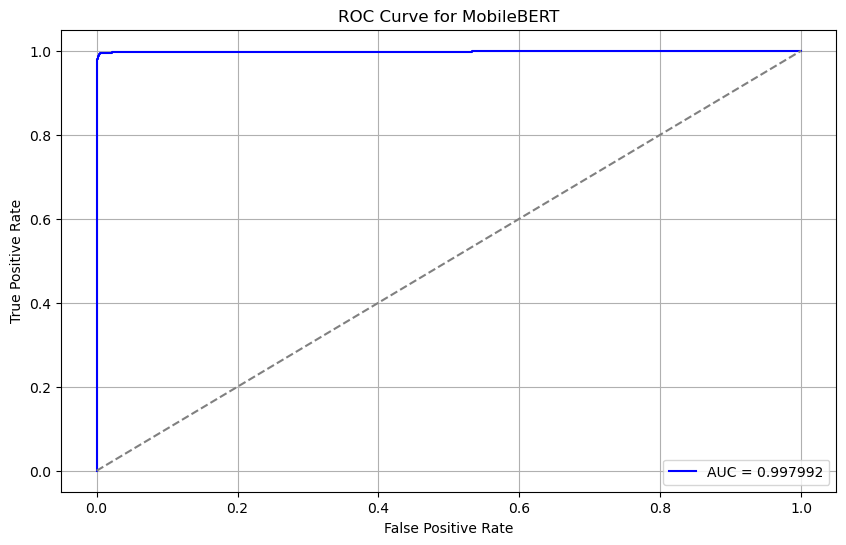

In [15]:
# Compute accuracy
accuracy = accuracy_score(labels.cpu(), pred_labels.cpu())
print(f"MobileBERT Accuracy: {accuracy:.6f}")

# Show classification report
print(classification_report(labels.cpu(), pred_labels.cpu(), digits=6))

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(labels.cpu(), pred_probs.cpu())
auc = roc_auc_score(labels.cpu(), pred_probs.cpu())
print(f"MobileBERT AUC: {auc:.6f}")

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.6f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for MobileBERT')
plt.legend(loc='lower right')
plt.grid()
plt.show()